In [17]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

from skorch import NeuralNetClassifier

from pathlib import Path
import os
import sys
import time
import copy

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

# Local modules
from cub_tools.train import train_model
from cub_tools.visualize import imshow, visualize_model
from cub_tools.utils import unpickle, save_pickle
from cub_tools.transforms import makeDefaultTransforms

In [18]:
# Script runtime options
model = 'resnet152'
data_root_dir = '../data'
model_root_dir = '../models'
stages = ['test']


# Paths setup
data_dir = os.path.join(data_root_dir,'images')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_history = os.path.join(output_dir,'model_history.pkl')
model_file = os.path.join(output_dir, 'caltech_birds_{}_full.pth'.format(model))

In [19]:
# Get data transforms
data_transforms = makeDefaultTransforms()

In [20]:
# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in stages}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in stages}
dataset_sizes = {x: len(image_datasets[x]) for x in stages}
class_names = image_datasets[stages[0]].classes


In [21]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


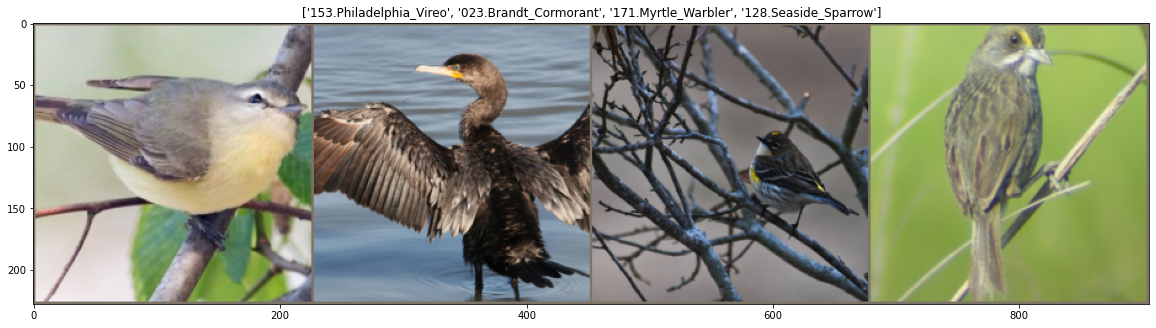

In [22]:
# Check the augmentations
# Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [23]:
# Load the best model from file
model_ = torch.load(model_file)

In [24]:
net = NeuralNetClassifier(model_)
net.initialize()

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=

In [26]:
print('Predicted: {}'.format(net.predict(inputs)))
print('Ground Truth: {}'.format(classes))

Predicted: [152  99 170 127]
Ground Truth: tensor([152,  22, 170, 127])


In [27]:
inputs = inputs.to(device)
outputs = model_(inputs)
_, preds = torch.max(outputs, 1)
preds

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

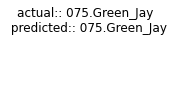

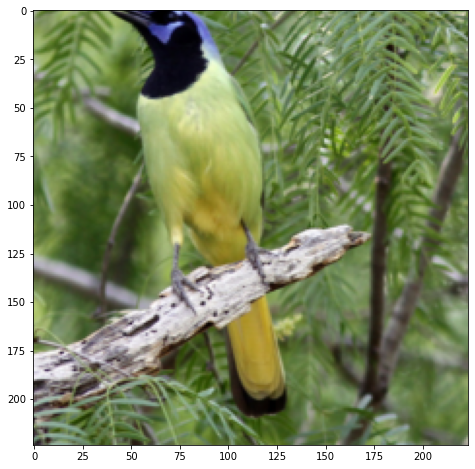

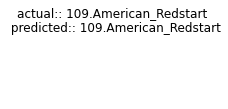

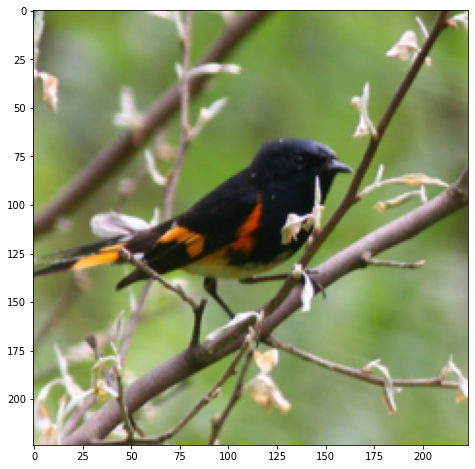

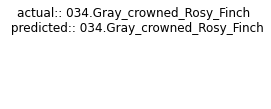

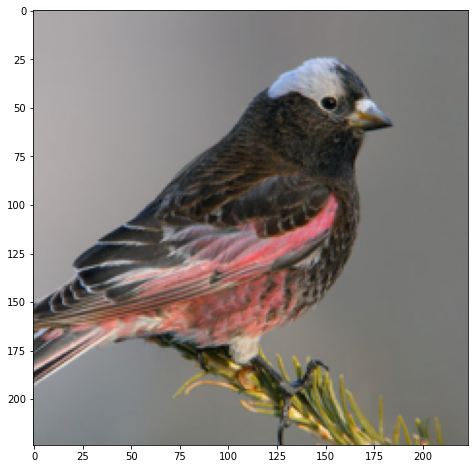

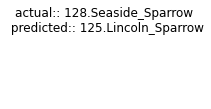

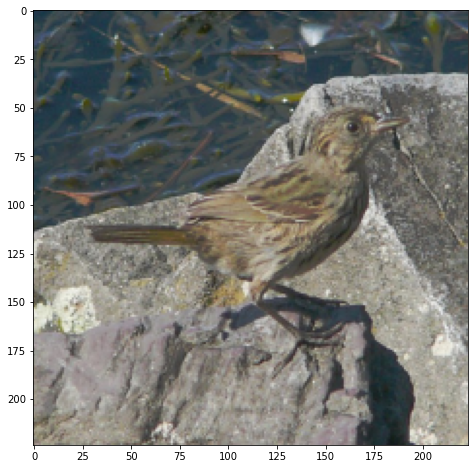

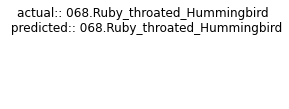

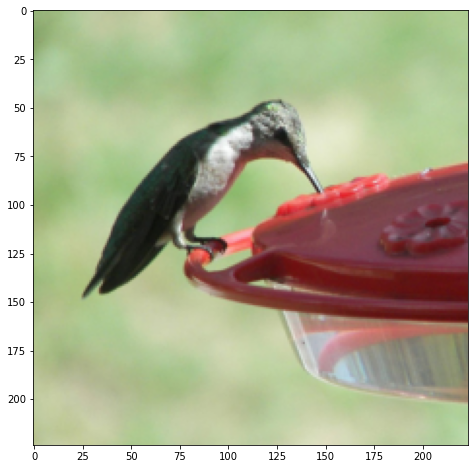

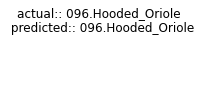

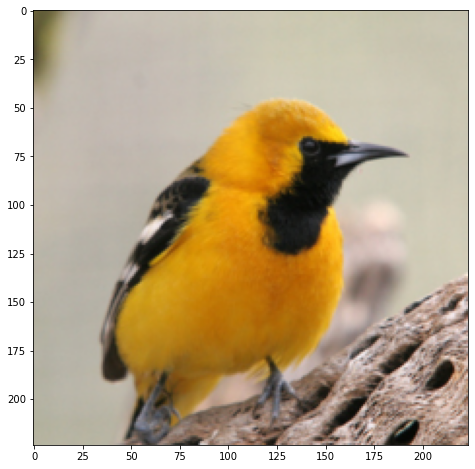

In [9]:
visualize_model(model=model_, class_names=class_names, device=device, dataloaders=dataloaders)

In [ ]:
# Load model training history
history = unpickle(model_history)

In [ ]:
plt.figure(figsize=(18,10))

plt.subplot(2,1,1)
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['train_loss'], 'b-', label='Train')
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['test_loss'], 'r-', label='Test')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training / Validation Loss - Caltech Birds - {}'.format(model))
plt.legend()

plt.subplot(2,1,2)
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['train_acc'], 'b-', label='Train')
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['test_acc'], 'r-', label='Test')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training / Validation Accuracy - Caltech Birds - {}'.format(model))
plt.legend()

plt.show()

In [ ]:
model_(inputs.to(device))

In [ ]:
was_training = model_.training
model_.eval()
images_so_far = 0


print('Commencing predictions minibatch..', end='')
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        if i % 25 == 0:
            print('{}..'.format(i), end='')

        inputs = inputs.to(device)
        labels = labels.to(device)
        

        outputs = model_(inputs)
        _, preds = torch.max(outputs, 1)

        if i == 0:
            labels_truth = labels.cpu().numpy()
            labels_pred = preds.cpu().numpy()
            scores_pred = outputs.cpu().numpy()
        else:
            labels_truth = np.concatenate((labels_truth,labels.cpu().numpy()))
            labels_pred = np.concatenate((labels_pred,preds.cpu().numpy()))
            scores_pred= np.concatenate((scores_pred,outputs.cpu().numpy()))

print('Complete.')

results_dict = {'labels truth' : labels_truth, 'labels pred' : labels_pred, 'scores pred' : scores_pred}

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

In [ ]:
print(classification_report(y_true=labels_truth, y_pred=labels_pred, target_names=class_names))

In [ ]:
class_report_df = pd.DataFrame(classification_report(y_true=labels_truth, y_pred=labels_pred, target_names=class_names, output_dict=True))
class_report_df

In [ ]:
plt.figure(figsize=(10,35))
class_report_df.transpose()['precision'][:-3].sort_values().plot(kind='barh')
plt.xlabel('Precision Score')
plt.grid(True)
plt.title(model)

plt.figure(figsize=(10,35))
class_report_df.transpose()['recall'][:-3].sort_values().plot(kind='barh')
plt.xlabel('Recall Score')
plt.title(model)
plt.grid(True)

plt.figure(figsize=(10,35))
class_report_df.transpose()['f1-score'][:-3].sort_values().plot(kind='barh')
plt.xlabel('F1 Score')
plt.title(model)
plt.grid(True)

plt.show()

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true=labels_truth, y_pred=labels_pred), index=class_names, columns=class_names)

In [ ]:
plt.figure(figsize=(40,40))
plt.imshow(confusion_matrix_df, cmap='Reds')
plt.xticks(np.arange(0,len(class_names),1), class_names, rotation=90)
plt.yticks(np.arange(0,len(class_names),1), class_names)
plt.colorbar()
plt.grid(True)
plt.title('CalTech Birds 200 Dataset - Confusion Matrix - Model {}'.format(model))
plt.show()

In [ ]:
class_report_df.to_pickle(os.path.join(output_dir,'classification_report.pkl'))
confusion_matrix_df.to_pickle(os.path.join(output_dir,'confusion_matrix.pkl'))
save_pickle(pkl_object=results_dict, fname=os.path.join(output_dir,'model_results.pkl'))

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [ ]:
results_dict.keys()

In [ ]:
results_dict['scores pred'].shape

In [ ]:
misclass_scores = []
for i in range(results_dict['scores pred'].shape[0]):
    if results_dict['labels truth'][i] != results_dict['labels pred'][i]:
        misclass_scores.append( 
            {
                'label truth' : results_dict['labels truth'][i],
                'label pred' : results_dict['labels pred'][i],
                'scores' : softmax(results_dict['scores pred'][i,:])
            }
        )

In [ ]:
pd.DataFrame(misclass_scores)

In [ ]:
misclass_scores_array = []
for m in misclass_scores:
    misclass_scores_array.append( m['scores'] )
misclass_scores_array = np.asarray(misclass_scores_array)

In [ ]:
misclass_scores_array.shape

In [ ]:
plt.figure(figsize=(40,25))
plt.imshow(misclass_scores_array, cmap='Reds', aspect='auto')
plt.xticks(np.arange(0,len(class_names),1), class_names, rotation=90)
#plt.yticks(np.arange(0,len(class_names),1), class_names)
plt.colorbar()
plt.grid(True)
plt.title('CalTech Birds 200 Dataset - Confusion Matrix - Model {}'.format(model))
plt.clim([0,1.0])
plt.show()

In [ ]:
test_img_i = 5

results = softmax(results_dict['scores pred'][test_img_i])

In [ ]:
plt.figure(figsize=(28,6))
plt.bar(class_names,height=results_dict['scores pred'][test_img_i])
plt.xticks(rotation=90)
plt.title('{} CUB-200-2011 \n Result:: True Label: {} \n Predicted Label: {}'.format(model, class_names[results_dict['labels truth'][test_img_i]], class_names[results_dict['labels pred'][test_img_i]]))
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(28,6))
plt.bar(class_names,height=results)
plt.xticks(rotation=90)
plt.title('{} CUB-200-2011 \n Result:: True Label: {} \n Predicted Label: {}'.format(model, class_names[results_dict['labels truth'][test_img_i]], class_names[results_dict['labels pred'][test_img_i]]))
plt.grid(True)
plt.tight_layout()
plt.ylim([0.0, 1.0])
plt.show()